In [1]:
import itertools
import matplotlib
from operator import itemgetter
import sys
sys.path.append('../methods')
from settings import *
import helpers
import interacting_with_regulondb as ir

%matplotlib inline
config_dict = helpers.process_config("config")

# Output
figures_dir = config_dict["out_dir"]["figures"]
results_dir = config_dict["out_dir"]["results"]

# Data
rdb = config_dict["db"]["path"]
cnts_file = config_dict['out_dir']['counts']

/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/methods/helpers.py


In [2]:
crp = pd.DataFrame.from_records(ir.get_regulon(rdb, 'crp'), columns=["regulator", "name", "locus_tag", 'function', 'mod'])
crp.shape #571, 5

(571, 5)

In [3]:
crp.head()

,regulator,name,locus_tag,function,mod
0,crp,lsrF,b1517,activator,CRP-cAMP
1,crp,lsrA,b1513,activator,CRP-cAMP
2,crp,mcaS,ECK120002610,activator,CRP-cAMP
3,crp,idnO,b4266,activator,CRP-cAMP
4,crp,lacY,b0343,repressor,CRP-cAMP


In [4]:
crp = crp[crp.function == 'activator'].set_index('name')

In [5]:
crp_bnums = crp.locus_tag.values
len(crp_bnums) #425

425

In [6]:
def get_subset_genes(df, key, col_return,column_name="Function"):
    keep = []
    if not type(key) == str:
        return df[df[column_name].isin(key)][col_return]
    for i, x in zip(df.index, df[column_name]):
        if not type(x) == str:
            continue
        if key in x:
            keep.append(i)
    return df.loc[keep][col_return]

df = pd.read_csv(config_dict['out_dir']['de_edited_file'], index_col=0)
rprotein = get_subset_genes(df, "ribosomal subunit protein", df.columns).index
len(rprotein) # 48

48

In [7]:
cnts = pd.read_csv(cnts_file, index_col=0)
to_keep = [c for c in cnts.columns if 'count' in c]
cnts = cnts[to_keep]
core_cnts = cnts.sum() # counts dedicated to core genome expression
ribosome_counts = cnts.loc[rprotein]
ribosome_sum = ribosome_counts.sum()
crp_in_core = set(crp_bnums).intersection(set(cnts.index))
crp_counts = cnts.loc[crp_in_core]
crp_sum = crp_counts.sum()

In [8]:
totals =  pd.DataFrame({'Core': core_cnts,'R-protein':ribosome_sum, 'Catabolic genes': crp_sum})
totals["C%"] = round(totals["Catabolic genes"]/totals["Core"]*100,2)
totals["R%"] = round(totals["R-protein"]/totals["Core"]*100,2)
totals['Sample'] = [ur  if 'UR' in c else uti for c in totals.index]
totals


,Core,R-protein,Catabolic genes,C%,R%,Sample
HM01_UR_count,8339516.0,364511.0,2229966.0,26.74,4.37,URINE
HM01_UTI_count,2270040.0,605552.0,260645.0,11.48,26.68,PATIENT
HM03_UR_count,11344027.0,523235.0,2561484.0,22.58,4.61,URINE
HM03_UTI_count,4913506.0,1397637.0,643289.0,13.09,28.44,PATIENT
HM06_UR_count,11789016.0,883421.0,2478077.0,21.02,7.49,URINE
HM06_UTI_count,2606614.0,506208.0,303138.0,11.63,19.42,PATIENT
HM07_UR_count,10917809.0,480849.0,2156924.0,19.76,4.40,URINE
HM07_UTI_count,1136237.0,253247.0,132565.0,11.67,22.29,PATIENT
HM14_UR_count,11278572.0,512872.0,2786211.0,24.70,4.55,URINE
HM14_UTI_count,7774529.0,2139952.0,1071556.0,13.78,27.53,PATIENT


In [9]:
flag = pd.read_csv(config_dict['flagstat']['summary'], index_col=0)
flag
flag.index = [f.split("_trimmed")[0]+"_count" for f in flag.index]
mapped = flag.loc[totals.index]['mapped']
totals['mapped'] = mapped
totals['% core'] = round(totals["Core"]/totals['mapped']*100, 2)
#totals.to_csv(os.path.join(results_dir, "percent_allocated.csv"))

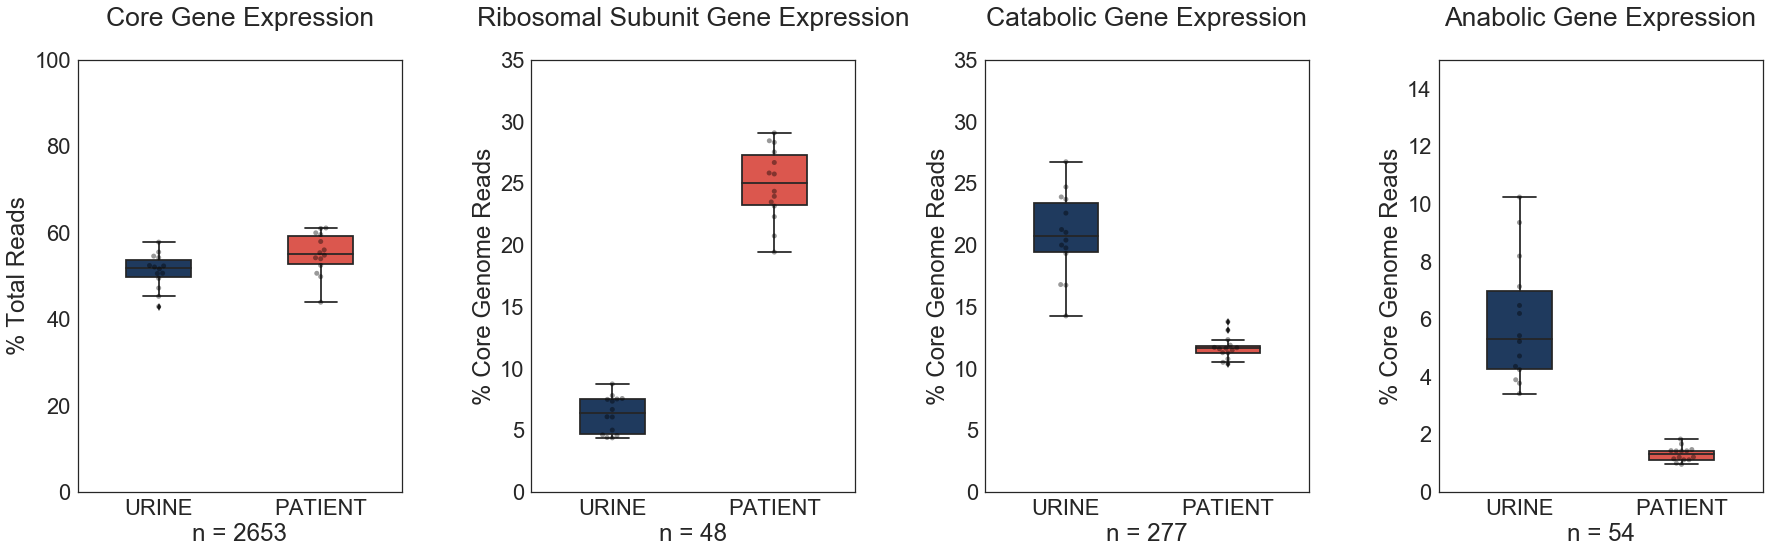

In [29]:
fig = plt.figure(figsize=(9,5))

sns.set(font_scale = 2.2)
sns.set_style("white")
# Core Gene Expression
ax1 = fig.add_axes([0.1, 0.5, 0.5, 1.2],
                    xticklabels=[], ylim=(0, 100))
#sns.violinplot(x = "Sample", y = "% core", palette=[col5, col1],data = totals,width=0.4)
sns.boxplot(x = "Sample", y = "% core", palette=[col5, col1],data = totals,width=0.4)
sns.swarmplot(x = "Sample", y = "% core", data = totals, color = 'black', alpha = 0.4)
ax1.set_title("Core Gene Expression\n")
ax1.set_xticklabels([ur, uti])
ax1.set_xlabel("n = {}".format(cnts.shape[0]))
ax1.set_ylabel("% Total Reads")

# Ribosome Subunits Gene Expression

ax2 = fig.add_axes([0.8, 0.5, 0.5, 1.2],
                    xticklabels=[], ylim=(0, 35))
#sns.violinplot(x = "Sample", y = "R%",palette=[col5, col1], data = totals, width=0.4)
sns.boxplot(x = "Sample", y = "R%",palette=[col5, col1], data = totals, width=0.4)
sns.swarmplot(x = "Sample", y = "R%", data =totals, color = 'black', alpha = 0.4)
ax2.set_title("Ribosomal Subunit Gene Expression\n")
ax2.set_xticklabels([ur, uti])
ax2.set_xlabel("n = {}".format(len(rprotein)))
ax2.set_ylabel("% Core Genome Reads")

# Catabolic Gene Expression

ax3 = fig.add_axes([1.5, 0.5, 0.5, 1.2],
                    xticklabels=[], ylim=(0, 35))
#sns.violinplot(x = "Sample", y = "C%", palette=[col5, col1], data = totals, width=0.4)
sns.boxplot(x = "Sample", y = "C%", palette=[col5, col1], data = totals, width=0.4)
sns.swarmplot(x = "Sample", y = "C%", data =totals, color = 'black', alpha = 0.4)
ax3.set_title("Catabolic Gene Expression\n")
ax3.set_xticklabels([ur, uti])
ax3.set_xlabel("n = {}".format(len(crp_in_core)))
ax3.set_ylabel("% Core Genome Reads")

ax4 = fig.add_axes([2.2, 0.5, 0.5, 1.2],
                    xticklabels=[], ylim=(0, 15))
sns.boxplot(x = "Sample", y = "A%", palette=[col5, col1], data = totals, width=0.4)
#sns.boxplot(x = "Sample", y = "C%", palette=[col5, col1], data = totals, width=0.4)
sns.swarmplot(x = "Sample", y = "A%", data =totals, color = 'black', alpha = 0.4)
ax4.set_title("Anabolic Gene Expression\n")
ax4.set_xticklabels([ur, uti])
ax4.set_xlabel("n = {}".format(aa_A_genes_counts.shape[0]))
ax4.set_ylabel("% Core Genome Reads")
fig.savefig(os.path.join(figures_dir, "Figure_4.png"),bbox_inches='tight',dpi=150 )

In [11]:
from Bio.KEGG import REST



paths = ["path:eco00010", "path:eco00020"]


def get_genes_for_pathway(pathway):
    genes = []
    pathway_file = REST.kegg_get(pathway).read()
    current_section = None
    for line in pathway_file.rstrip().split("\n"):
        section = line[:12].strip()  # section names are within 12 columns
        if not section == "":
            current_section = section

        if current_section == "GENE":
            gene_identifiers = line[12:].split("; ")[0]
            gene_id, gene_symbol = gene_identifiers.split()

            if not gene_symbol in genes:
                genes.append(gene_id)
    return genes


In [12]:
glu = get_genes_for_pathway("path:eco00010")
tca = get_genes_for_pathway("path:eco00020")

In [13]:
glu_counts = cnts.loc[[g for g in glu if g in cnts.index]]
glu_sum = glu_counts.sum()
tca_counts = cnts.loc[[g for g in tca if g in cnts.index]]
tca_sum = tca_counts.sum()

In [14]:
tca_p = tca_sum/core_cnts*100
tca_p

HM01_UR_count     4.687370
HM01_UTI_count    4.475736
HM03_UR_count     2.846793
HM03_UTI_count    4.434145
HM06_UR_count     2.817054
HM06_UTI_count    3.058911
HM07_UR_count     2.389472
HM07_UTI_count    2.985997
HM14_UR_count     3.392832
HM14_UTI_count    5.360801
HM17_UR_count     3.743441
HM17_UTI_count    1.686396
HM43_UR_count     4.542817
HM43_UTI_count    2.268934
HM54_UR_count     5.093313
HM54_UTI_count    2.453942
HM56_UR_count     4.283372
HM56_UTI_count    3.437324
HM57_UR_count     5.727371
HM57_UTI_count    2.382433
HM60_UR_count     5.576690
HM60_UTI_count    2.795895
HM66_UR_count     3.496433
HM66_UTI_count    1.526783
HM68_UR_count     4.525730
HM68_UTI_count    2.335196
HM86_UR_count     3.733951
HM86_UTI_count    1.415132
dtype: float64

In [15]:
totals["Glycolysis"] = glu_sum/core_cnts*100

met_summary = totals.pivot_table(["TCA", "Glycolysis"], index="Sample").sort_index(ascending=False)#.plot(kind='bar', stacked=True, figsize=(6,10))
met_summary = met_summary[['TCA', 'Glycolysis']]
met_summary.plot(kind='bar', stacked=True, figsize=(6,10), color=[col1, col5])
plt.ylabel("% Core Genome Reads")
plt.ylim(0,10)


KeyError: 'TCA'

In [16]:
aa_biosynthesis = "eco00290,eco00300,eco00220,eco00400".split(",")
glycan_biosynthesis = "eco00550 eco00540".split()
lipid_biosynthesis = "eco00061 eco00121 eco01040".split()

aa_A_genes = []
glycan_genes = []
lipid_genes = []

for p in aa_biosynthesis:
    aa_A_genes+= get_genes_for_pathway(p)

for p in glycan_biosynthesis:
    glycan_genes += get_genes_for_pathway(p)
    
for p in lipid_biosynthesis:
    lipid_genes+= get_genes_for_pathway(p)

In [17]:
def get_percentage(gene_list, cnts_df):
    counts = cnts_df.loc[[g for g in gene_list if g in cnts_df.index]]
    return counts.sum()/cnts_df.sum()*100

In [18]:
aa_A_sum = get_percentage(aa_A_genes, cnts)
glycan_sum = get_percentage(glycan_genes, cnts)
lipid_sum = get_percentage(lipid_genes, cnts)

In [28]:
aa_A_genes_counts = cnts.loc[[g for g in aa_A_genes if g in cnts.index]]

In [19]:
lipid_sum

HM01_UR_count     0.865986
HM01_UTI_count    1.773185
HM03_UR_count     0.861934
HM03_UTI_count    1.834291
HM06_UR_count     0.956908
HM06_UTI_count    1.687822
HM07_UR_count     0.942195
HM07_UTI_count    2.027570
HM14_UR_count     0.808116
HM14_UTI_count    1.460204
HM17_UR_count     0.907755
HM17_UTI_count    2.027795
HM43_UR_count     1.136779
HM43_UTI_count    1.496306
HM54_UR_count     0.979775
HM54_UTI_count    1.898406
HM56_UR_count     0.857980
HM56_UTI_count    2.008153
HM57_UR_count     0.971304
HM57_UTI_count    2.033468
HM60_UR_count     0.971070
HM60_UTI_count    2.221428
HM66_UR_count     0.860516
HM66_UTI_count    1.481122
HM68_UR_count     1.395318
HM68_UTI_count    1.942780
HM86_UR_count     0.975743
HM86_UTI_count    2.086315
dtype: float64

In [20]:
A_genes = aa_A_genes + glycan_genes + lipid_genes

In [21]:
A_sum = get_percentage(A_genes, cnts)

In [22]:
A_sum

HM01_UR_count      5.517526
HM01_UTI_count     4.108430
HM03_UR_count      7.079699
HM03_UTI_count     3.785423
HM06_UR_count      8.208022
HM06_UTI_count     4.314678
HM07_UR_count      6.324804
HM07_UTI_count     4.154591
HM14_UR_count      5.592800
HM14_UTI_count     3.430690
HM17_UR_count     11.203032
HM17_UTI_count     4.478637
HM43_UR_count      6.361564
HM43_UTI_count     3.897061
HM54_UR_count      6.572052
HM54_UTI_count     4.532470
HM56_UR_count      9.910538
HM56_UTI_count     3.974749
HM57_UR_count      5.278826
HM57_UTI_count     4.237403
HM60_UR_count      8.287198
HM60_UTI_count     4.564474
HM66_UR_count      8.965234
HM66_UTI_count     4.506150
HM68_UR_count      8.154987
HM68_UTI_count     4.423809
HM86_UR_count     12.130073
HM86_UTI_count     4.781494
dtype: float64

In [23]:
aa_A_sum

HM01_UR_count      3.769991
HM01_UTI_count     1.198966
HM03_UR_count      5.218226
HM03_UTI_count     0.952945
HM06_UR_count      6.192357
HM06_UTI_count     1.429134
HM07_UR_count      4.354564
HM07_UTI_count     1.144392
HM14_UR_count      3.890626
HM14_UTI_count     1.111746
HM17_UR_count      9.350519
HM17_UTI_count     1.420851
HM43_UR_count      4.242706
HM43_UTI_count     1.467607
HM54_UR_count      4.715684
HM54_UTI_count     1.416321
HM56_UR_count      8.184415
HM56_UTI_count     0.994176
HM57_UR_count      3.410692
HM57_UTI_count     1.109894
HM60_UR_count      6.470377
HM60_UTI_count     1.204357
HM66_UR_count      7.126536
HM66_UTI_count     1.832139
HM68_UR_count      5.421713
HM68_UTI_count     1.423213
HM86_UR_count     10.234743
HM86_UTI_count     1.661730
dtype: float64

In [126]:
glycan_sum

HM01_UR_count     0.881550
HM01_UTI_count    1.136280
HM03_UR_count     0.999539
HM03_UTI_count    0.998187
HM06_UR_count     1.058757
HM06_UTI_count    1.197722
HM07_UR_count     1.028045
HM07_UTI_count    0.982630
HM14_UR_count     0.894058
HM14_UTI_count    0.858740
HM17_UR_count     0.944757
HM17_UTI_count    1.029991
HM43_UR_count     0.982080
HM43_UTI_count    0.933148
HM54_UR_count     0.876594
HM54_UTI_count    1.217742
HM56_UR_count     0.868143
HM56_UTI_count    0.972420
HM57_UR_count     0.896830
HM57_UTI_count    1.094041
HM60_UR_count     0.845750
HM60_UTI_count    1.138689
HM66_UR_count     0.978181
HM66_UTI_count    1.192888
HM68_UR_count     1.337955
HM68_UTI_count    1.057817
HM86_UR_count     0.919588
HM86_UTI_count    1.033450
dtype: float64

In [127]:
len(aa_A_genes)

68

In [128]:
len(lipid_genes)

20

In [129]:
lipid_sum

HM01_UR_count     0.865986
HM01_UTI_count    1.773185
HM03_UR_count     0.861934
HM03_UTI_count    1.834291
HM06_UR_count     0.956908
HM06_UTI_count    1.687822
HM07_UR_count     0.942195
HM07_UTI_count    2.027570
HM14_UR_count     0.808116
HM14_UTI_count    1.460204
HM17_UR_count     0.907755
HM17_UTI_count    2.027795
HM43_UR_count     1.136779
HM43_UTI_count    1.496306
HM54_UR_count     0.979775
HM54_UTI_count    1.898406
HM56_UR_count     0.857980
HM56_UTI_count    2.008153
HM57_UR_count     0.971304
HM57_UTI_count    2.033468
HM60_UR_count     0.971070
HM60_UTI_count    2.221428
HM66_UR_count     0.860516
HM66_UTI_count    1.481122
HM68_UR_count     1.395318
HM68_UTI_count    1.942780
HM86_UR_count     0.975743
HM86_UTI_count    2.086315
dtype: float64

In [24]:
totals["A%"] = aa_A_sum

In [26]:
aa_A_genes

['b3117',
 'b3772',
 'b0072',
 'b0071',
 'b0073',
 'b0077',
 'b3671',
 'b0078',
 'b3670',
 'b3769',
 'b3774',
 'b3771',
 'b3770',
 'b3572',
 'b2290',
 'b0074',
 'b4024',
 'b0002',
 'b3940',
 'b3433',
 'b2478',
 'b0031',
 'b0166',
 'b3359',
 'b2472',
 'b3809',
 'b2838',
 'b0085',
 'b0086',
 'b0273',
 'b4254',
 'b3172',
 'b3960',
 'b1524',
 'b0485',
 'b3870',
 'b1761',
 'b2874',
 'b0323',
 'b0521',
 'b0928',
 'b2290',
 'b2818',
 'b3959',
 'b3958',
 'b3359',
 'b3957',
 'b0754',
 'b1704',
 'b2601',
 'b3389',
 'b1693',
 'b3281',
 'b1692',
 'b0388',
 'b3390',
 'b0908',
 'b2329',
 'b1264',
 'b1263',
 'b1262',
 'b1260',
 'b1261',
 'b2600',
 'b2599',
 'b0928',
 'b2021',
 'b4054']

In [144]:
lrp_genes = {'b0077',
 'b0078',
 'b0889',
 'b0907',
 'b1190',
 'b1243',
 'b1244',
 'b1245',
 'b1246',
 'b1247',
 'b1482',
 'b1798',
 'b2156',
 'b2163',
 'b2211',
 'b2290',
 'b2662',
 'b2663',
 'b2669',
 'b2903',
 'b2904',
 'b2905',
 'b2912',
 'b2913',
 'b2923',
 'b3212',
 'b3418',
 'b3454',
 'b3455',
 'b3456',
 'b3457',
 'b3508',
 'b3509',
 'b3510',
 'b3572',
 'b3617',
 'b3769',
 'b3770',
 'b3771',
 'b3772',
 'b4132',
 'b4187'}

In [145]:
aagenes=set(aa_A_genes)

In [146]:
aagenes.intersection(lrp_genes)

{'b0077', 'b0078', 'b2290', 'b3572', 'b3769', 'b3770', 'b3771', 'b3772'}

In [147]:
lrp_l = set(['b4009', 'b2588', 'b2589', 'b3272', 'b3275', 'ECK120048853',
       'b3769', 'ECK120002505', 'b3853', 'b3971', 'b3969', 'b0201',
       'b3273', 'b3460', 'b3508', 'ECK120004461', 'b3766', 'b4010',
       'b4007', 'b3274', 'b3277', 'b2215', 'b1798', 'b3572', 'b3970',
       'b3759', 'b3758', 'b3756', 'b3510', 'b2290', 'b2913', 'b2591',
       'b3772', 'ECK120000491', 'b3855', 'b3854', 'b4008', 'b0205',
       'b3276', 'b3278', 'b3852', 'b0202', 'b3968', 'b3757', 'b0889',
       'b3771', 'b3851', 'b2590', 'b0204', 'b0203', 'b3509', 'b3770'])

In [148]:
aagenes.intersection(lrp_l)

{'b2290', 'b3572', 'b3769', 'b3770', 'b3771', 'b3772'}

42

52